In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [67]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Modélisation type "boites grisses" du comportement thermique de mon appartement

Je mesure et enregistre la température intérieure de mon appartement avec le système proposé par [Open Energy Monitor](https://openenergymonitor.org/). C'est un Raspberry pi qui log les mesures de plusieurs capteurs de température. 

J'ai donc l'historique de la température intérieur de mon appartement toutes les 15 minutes. 




On souhaite le modèle le plus simple possible, avec seulement deux coefficients : la résistance thermique $h$ avec l'extérieure, une masse thermique $M$ et un flux de chaleur externe $\eta\Phi(t)$.

Schéma électrique équivalent :
![schéma eq.](images/sch_blackbox02.png)

et l'équation différentielle corespondante:
$$
 \frac{dT}{dt} = \frac{h}{M} \,\left[ T_{ext}(t) - T \right] + \frac{\eta}{M} \, \Phi(t)
$$

en été, l'isolation (h) et le masquage du rayonement solaire dépend beaucoup l'aération (ouverture des fêntres la nuit) et de l'utilisation des rideaux la journée. Ces deux coefficient ne sont donc pas constant mais varie suivant 

Une semaine en vacances, pendant l'états de l'appartemetn est resté le même. 





//plan

- chargement de données
- Modèle
- fit et estimation des paramètres
- Vérifications des valeurs


## Chargement des données

Le chargements des données est effectuée dans le [notebook testweek_get_data](testweek_get_data.ipynb) puis le dataframe (Pandas) est enregistré avec Pickle. 

In [393]:
df  = pd.read_pickle( 'weektest_data.pck' )
print( ', '.join(df.columns) )

cloudCover, humidity, precipIntensity, temperature, windBearing, windGust, windSpeed, flux_tot, T_int


Les colones qui nous intéresse ici sont la température intérieure mesurée `T_int`, la température extérieure `temperature` et flux de chaleur sur les vitres `flux_tot`: 

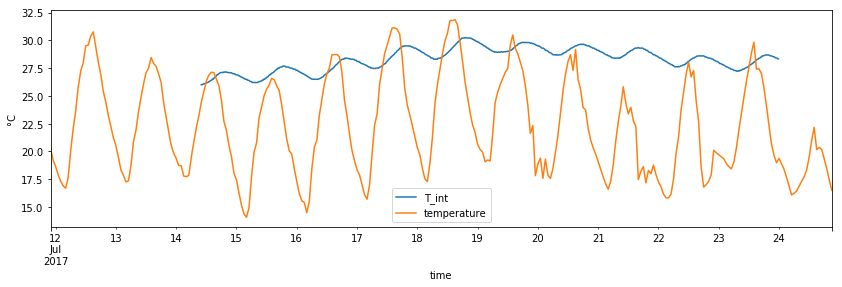

In [394]:
df[['T_int', 'temperature']].plot( figsize=(14, 4) ); plt.ylabel('°C');

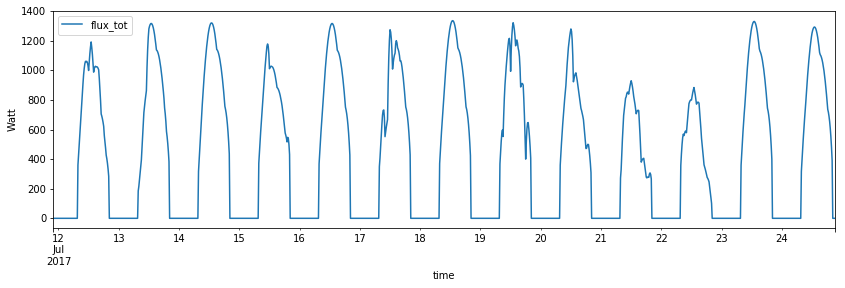

In [72]:
# Flux solaire sur les vitres:
df[['flux_tot']].plot( figsize=(14, 4) ); plt.ylabel('Watt');

# Modèle

L'équation différentielle est résolue simplement avec `odeint` de _scipy_. Le système étant linéaire il est possible de passé par la transformée de Fourier, mais...

In [73]:
from scipy.integrate import odeint

In [396]:
def get_dTdt(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température par rapport au temps
        params :   [ h/M  ,  eta/M ]
        get_Text, get_Phi : fonctions d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt = params[0] * ( T_ext - T ) + params[1] / 100 * phi
    
    return 1e-6*dTdt


def apply_model( data, T_start, params, full_output=False, fasttol=True ):

    rtol, atol = 1e-8, 1e-8
    if fasttol:
        rtol, atol = 1e-3, 1e-4
        
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en seconde

    # Construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60, col_deriv=True, rtol=rtol, atol=atol)
    # h0 : pas de temps initial utilisé par le solveur
    
    return T_theo.flatten()

In [397]:
Tzero = df['T_int'].mean()
params =  ( 4, 5, Tzero ) # k/M, 100*eta/M, T( t=0 )

T_theo = apply_model( df, Tzero, params )

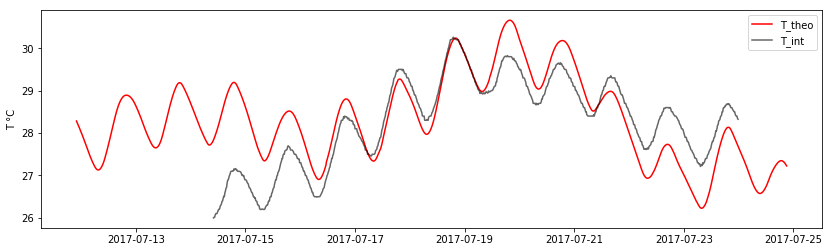

In [398]:
# graph
plt.figure( figsize=(14, 4) )
plt.plot( df.index, T_theo, 'r', label='T_theo')
plt.plot( df['T_int'], 'k', alpha=0.6) ;
plt.legend(); plt.ylabel('T °C');

# Optimisation

In [399]:
from scipy.optimize import minimize

In [400]:
def get_errorfit( params, data ):
    """ Applique le modèle pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    T_start = params[0]
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model( data, T_start, params[1:] )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [401]:
get_errorfit( params, df    )

267688.05727212928

In [358]:
paramsZero = ( 27, 2.5, 3 )

In [359]:
opti_res = minimize(get_errorfit, paramsZero, args=(df), method='Nelder-Mead')
print( opti_res )

 final_simplex: (array([[ 24.71572253,   2.3099046 ,   3.48994313],
       [ 24.71572253,   2.3099046 ,   3.48994313],
       [ 24.71572253,   2.3099046 ,   3.48994313],
       [ 24.71572253,   2.3099046 ,   3.48994313]]), array([ 65.79243696,  65.79243696,  65.79243696,  65.79244087]))
           fun: 65.792436955967446
       message: 'Optimization terminated successfully.'
          nfev: 238
           nit: 97
        status: 0
       success: True
             x: array([ 24.71572253,   2.3099046 ,   3.48994313])


In [405]:
Tzero = opti_res.x[0] # df['T_int'].mean()
params_opti = opti_res.x[1:]

T_theo = apply_model( df, Tzero, params_opti, fasttol=False )

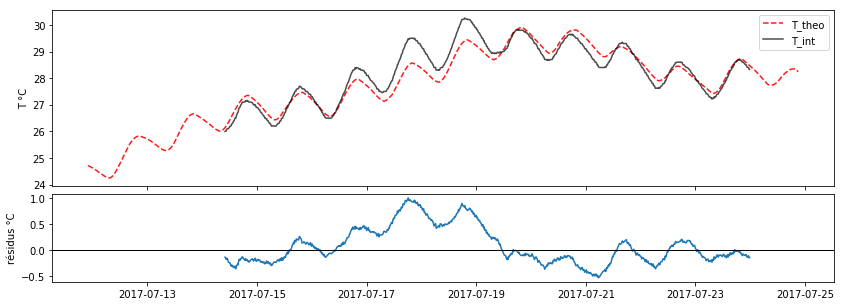

In [406]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].plot( df.index,  df['T_int'].as_matrix()-res ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)


$ h/m \sim 2.3e-6  $

Comment expliquer l'écart entre le 17 et le 19 juillet ? Il ne semble pas avoir eu de pluie, 

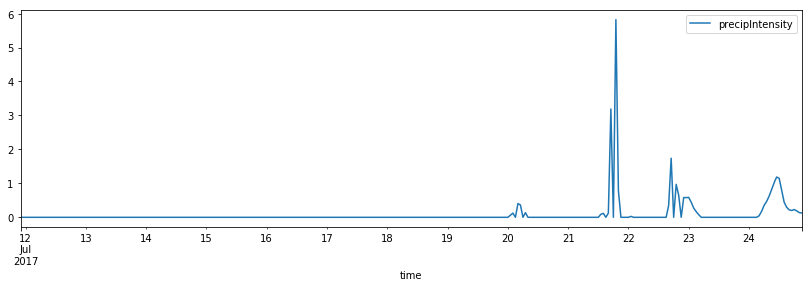

In [176]:
df_full[['precipIntensity']].plot(figsize=(14, 4) )

* Tester avec d'autre donné météo... mais il n'y a pas d'en d'écart que cela
* Une masse thermique 'longue' ?

In [ ]:
df_full[['precip', 'windGust']].plot(figsize=(14, 4) )

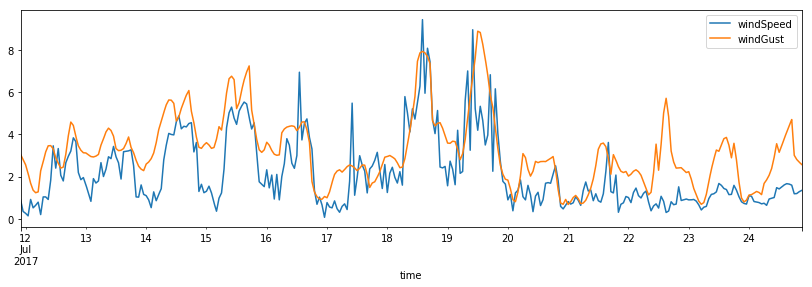

In [174]:
df_full[['windSpeed', 'windGust']].plot(figsize=(14, 4) )

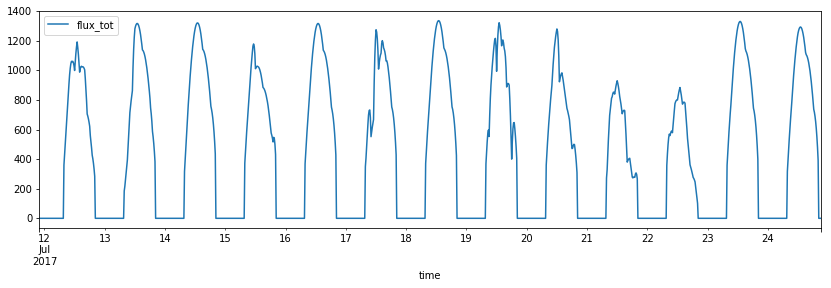

In [144]:
df_full[['flux_tot']].plot(figsize=(14, 4) )

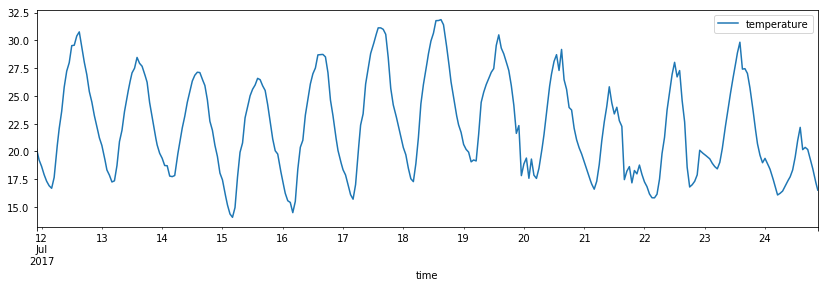

In [145]:
df_full[['temperature']].plot(figsize=(14, 4) )

# Transformé de Fourier

In [270]:
def apply_modelTF( data,  params ):

    params = np.array( params ) * 1e-6
    
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en secondes
    dt = np.diff( time_sec )[0] 
    n =  len( time_sec )
    
    # TF (reel)
    TF_ext =   np.fft.rfft( data_dict['temperature']  )
    TF_flux =  np.fft.rfft( data_dict['flux_tot']    )
    
    freq = np.fft.rfftfreq(n, d= dt)
    
    # modele
    source = params[0] * TF_ext  + params[1] * TF_flux / 100
    divide  =  params[0] +  2j*np.pi*freq 
    
    TF_theo = source/divide

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=n )
    
    return T_theo

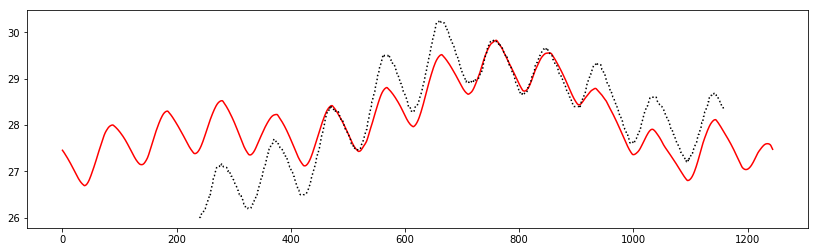

In [280]:
params = [ 2.62922866,  3.40189379 ]
res = apply_modelTF( df,  params)

plt.figure( figsize=(14, 4) )
plt.plot( res, 'r' )
plt.plot( df['T_int'].as_matrix(), ':k' ) ;


In [273]:
def get_errorfit_TF( params, data ):
    """ Calcul le modele pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_modelTF( data, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [290]:
get_errorfit_TF([5, 5], df  )

1988.3406636786026

Comme la résolution du modèle est plutôt rapide, on peut calculer et visualiser l'erreur du modèle pour une zone de l'espace des paramètres : 

In [328]:
n, m = 44, 44
E = np.zeros( (n, m) )
for i, k in enumerate( np.linspace(2, 10, n) ):
    for j, eta in enumerate( np.linspace(2, 10, m)):
        E[i][j] = get_errorfit_TF([k, eta], df  )

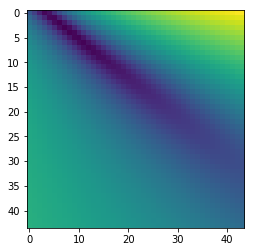

In [329]:
plt.imshow(np.log( E))

In [277]:
opti_res = minimize(get_errorfit_TF, paramsZero, args=(df), method='Nelder-Mead')
print( opti_res )

 final_simplex: (array([[ 2.62922866,  3.40189379],
       [ 2.62929863,  3.40196762],
       [ 2.62926465,  3.40194773]]), array([ 350.32868479,  350.32868493,  350.32868515]))
           fun: 350.32868479494562
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 52
        status: 0
       success: True
             x: array([ 2.62922866,  3.40189379])


# Modèle avec la masse thermique des murs

In [453]:
def get_dTdt_wall(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température par rapport au temps
        params :   [ h/M  ,  eta/M, kw/M, kw/Mw ]
        get_Text, get_Phi : fonctions d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt_w = params[3]*( T[1] - T[0]  )
    dTdt_i = params[0] * ( T_ext - T[1] ) + params[1] * phi /100  + params[2]*( T[0] - T[1]  )
    
    return 1e-6*np.array( [ dTdt_w, dTdt_i] )


def apply_model_wall( data, params, full_output=False, fasttol=True, flatten=True ):

    rtol, atol = 1e-8, 1e-8
    if fasttol:
        rtol, atol = 1e-3, 1e-4
        
    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 1e9    # conversion en seconde

    T_start = params[4:]
    
    # Construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt_wall, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60, col_deriv=True, rtol=rtol, atol=atol)
    # h0 : pas de temps initial utilisé par le solveur
    
    if flatten :
        T_theo = T_theo[:, 1].flatten()
        
    return T_theo

In [494]:
params =  (  2.3099046 , 3.48994313, 1.1 , 2.1, 24, 24.7 ) # k/M, 100*eta/M, T( t=0 )

T_theo = apply_model_wall( df, params )

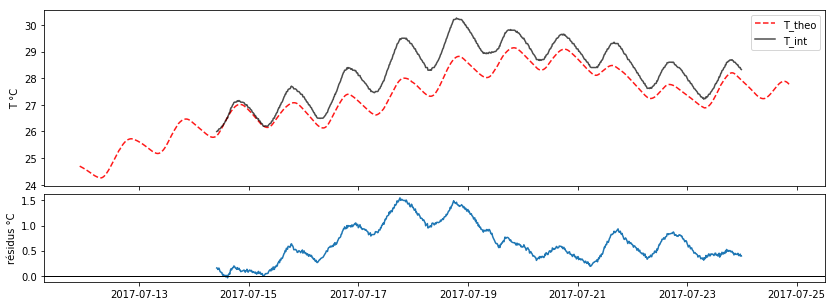

In [495]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].plot( df.index,  df['T_int'].as_matrix()-T_theo ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)

In [469]:
def get_errorfit_wall( params, data ):
    """ Applique le modèle pour les données et les paramètres
        puis calcul l'erreur avec les données expérimentals (non NaN)
    """
    T_start = params[0:2]
    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model_wall( data, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )

In [470]:
get_errorfit_wall( params, df )

5336.7301819103668

In [496]:
paramsZero = (  2.3099046 , 3.48994313, 1.1 , 2.1, 24, 24.7 )

In [497]:
opti_res = minimize(get_errorfit_wall, paramsZero, args=(df), method='Nelder-Mead')
print( opti_res )

 final_simplex: (array([[  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634],
       [  2.18839707,   3.65616101,   1.09947719,   2.18343498,
         24.61680173,  25.17646634]]), array([ 84.11204394,  84.11204394,  84.11204394,  84.11204394,
        84.11204394,  84.11204394,  84.11204394]))
           fun: 84.112043940899113
       message: 'Optimization terminated successfully.'
          nfev: 406
           nit: 149
        status: 0
       succ

In [474]:
params_opti = opti_res.x

T_theo = apply_model_wall( df, params_opti , fasttol=False )

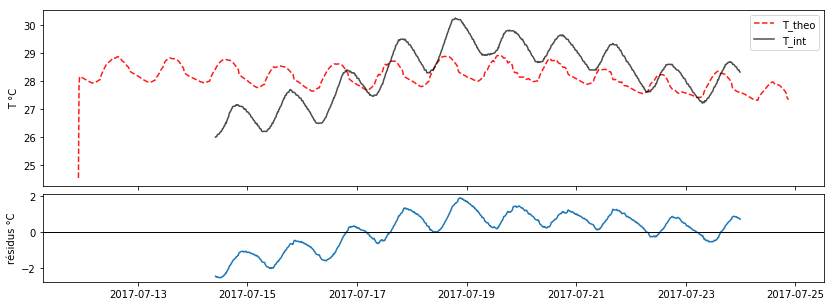

In [475]:
# graph
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 5), gridspec_kw = {'height_ratios':[2, 1]} )

ax[0].plot( df.index, T_theo, '--r', label='T_theo', alpha=0.9)
ax[0].plot( df['T_int'], 'k', alpha=0.7) ;
ax[0].legend(); ax[0].set_ylabel('T °C');

ax[1].plot( df.index,  df['T_int'].as_matrix()-T_theo ) ;
ax[1].axhline(y=0., color='k', linestyle='-', linewidth=1); ax[1].set_ylabel('résidus °C');

plt.subplots_adjust(hspace=0.06)